In [1]:
import matplotlib.font_manager as font_manager
import alphashape
import osmnx as ox
import networkx as nx
from shapely.ops import unary_union
from shapely.geometry import Polygon
import osmnx as osmnx
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy

fontsize = 20
# fontsize_ax_ticks = 25
# fontsize_legend = 25
figsize = (15, 10)
font = 'Times New Roman'

resultpath = 'results/'
network_polygon = '../../data/network/QGIS_Project/referentiel-comptages-edit.shp'

cycleways = gpd.read_file('../../data/cycleways_2000-2022.geojson')
plan_velo_2026 = gpd.read_file('../../data/plan-velo-2026.geojson')
paris_districts = gpd.read_file('../../data/districts_paris.geojson')

polygon_all_districts = paris_districts.unary_union

def get_exterior_coords(df, start_point, end_point):
    filtered_gdf = df[(df["c_ar"] >= start_point) & (df["c_ar"] <= end_point)]

    # Check if there are any polygons matching the condition
    if not filtered_gdf.empty:
        # Apply unary_union to combine the selected polygons into a single polygon
        districts_polygon = unary_union(filtered_gdf["geometry"])
    else:
        # If no polygons match the condition, union_polygon will be None
        districts_polygon = None

    return districts_polygon.exterior.coords.xy

In [2]:
# cycleways_red = cycleways[cycleways['typologie_simple'] == 'Pistes cyclables']
# cycleways_2010_2023 = cycleways[cycleways['date_de_livraison'] >= "2010-01-01"]
# cycleways_2010_2023_red = cycleways_2010_2023[cycleways_2010_2023['typologie_simple'] == 'Pistes cyclables']

In [3]:
qgis_road_network = gpd.read_file(network_polygon)
qgis_road_network.crs = "EPSG:4326"
alpha_shape = alphashape.alphashape(qgis_road_network, 435)
coordinates = list(alpha_shape.exterior[0].coords)
polygon = Polygon(coordinates)
x_coords, y_coords = zip(*coordinates)

In [4]:
# get OSM dataframe
ox.settings.log_console = True
G_road_network = ox.graph_from_polygon(
    polygon_all_districts, simplify=True, network_type="drive")
nodes_osm, df_osm = momepy.nx_to_gdf(G_road_network, points=True, lines=True)
df_osm['osm_id'] = range(1, len(df_osm) + 1)

# ox.settings.log_console = True
# G_bike_network = ox.graph_from_polygon(
#     polygon_all_districts, simplify=True, network_type="bike")
# nodes_osm, df_osm_bike = momepy.nx_to_gdf(G_bike_network, points=True, lines=True)
# df_osm_bike['osm_id'] = range(1, len(df_osm_bike) + 1)

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_1252/3194263993.py:5: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes_osm, df_osm = momepy.nx_to_gdf(G_road_network, points=True, lines=True)


In [9]:
higher_order_roads = ['tertiary', 'secondary', 'primary', 'secondary_link', 'primary_link', 'tertiary_link']

df_osm_only_hor = df_osm[df_osm['highway'].isin(higher_order_roads)]

In [11]:
len(df_osm)

18256

In [10]:
len(df_osm_only_hor)

8122

In [5]:
x_district_1_4, y_district_1_4  = get_exterior_coords(paris_districts, 1, 4)
x_district_5_7, y_district_5_7  = get_exterior_coords(paris_districts, 5, 7)

{'pink': [3, 4, 11, 20], 'LightGreen': [9, 8, 17, 16], 'LightSkyBlue': [1, 6, 14, 15]}


/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_1252/3076597440.py:101: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(paris_districts.geometry.centroid.x, paris_districts.geometry.centroid.y, paris_districts.c_ar):


[3, 4, 11, 20]
[9, 8, 17, 16]
[1, 6, 14, 15]
[[<matplotlib.patches.Patch object at 0x28f9f7d90>], [<matplotlib.patches.Patch object at 0x28451bdc0>], [<matplotlib.patches.Patch object at 0x2845585b0>]]


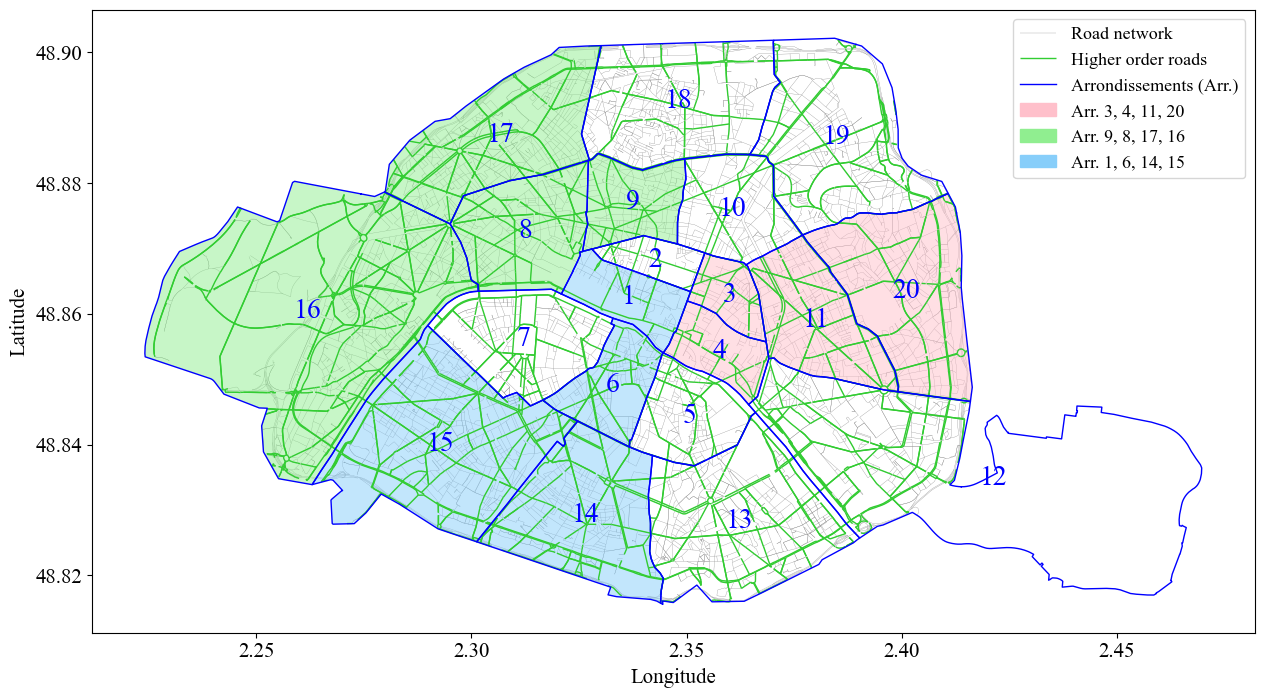

In [39]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

arr_to_plot = [3, 4, 11, 20]

def list_to_string(list_of_int, delimiter=', '):
    """
    Converts a list of integers into a string, with each integer separated by the specified delimiter.

    Parameters:
    integers (list of int): The list of integers to convert.
    delimiter (str): The delimiter to use between integers in the string.

    Returns:
    str: A string representation of the list of integers.
    """
    return delimiter.join(map(str, list_of_int))

def plot_this(arr_to_highlight: list):

    fig, ax = plt.subplots(figsize=figsize)
    df_osm.plot(ax = ax, color = "grey", linewidth = 0.2, label = "Road network", zorder = 1)
    # plan_velo_2026.plot(ax = ax, color =(50/255, 205/255, 50/255), linewidth = 1, label = "Plan Vélo II (plan until 2026)")
    # cycleways_2010_2023.plot(ax = ax, color = "red", linewidth = 1, label = "Cycleways")

    df_osm_only_hor.plot(ax = ax, color = (50/255, 205/255, 50/255), linewidth = 1, label = "Higher order roads", zorder = 2)

    for idx, row in paris_districts.iterrows():
        # Plot each polygon
        x, y = row['geometry'].exterior.xy
        if idx == 0:
            plt.plot(x, y, color = "blue", linewidth = 1, label = 'Arrondissements (Arr.)', zorder = 3)
        else: 
            plt.plot(x, y, color = "blue", linewidth = 1)
            
        if row['c_ar'] in [3, 4, 11, 20]:
            paris_districts[paris_districts['c_ar'] == row['c_ar']].plot(ax=ax, color='pink', alpha=0.5, edgecolor='black', linewidth=1.5)

    for x, y, label in zip(paris_districts.geometry.centroid.x, paris_districts.geometry.centroid.y, paris_districts.c_ar):
        ax.text(x, y, label, color = 'blue', fontsize=fontsize, font = font, ha='center', va='center') 
        
    # Add custom legend entry for the pink districts
    legend_patches = [Patch(color='pink', label="Arr " + list_to_string(list_of_int=arr_to_highlight, delimiter=', '))]
    handles, labels = ax.get_legend_handles_labels()
    handles.extend(legend_patches)

    plt.xticks(font = font, fontsize = 15)
    plt.yticks(font = font, fontsize = 15)
    plt.xlabel("Longitude", font = font, fontsize = 15)
    plt.ylabel("Latitude", font = font, fontsize = 15)
    font_legend = font_manager.FontProperties(family=font, style='normal', size=13)
    ax.legend(handles=handles, loc='upper right', prop=font_legend)
    plt.savefig("results/arrondissements_" + list_to_string(list_of_int=arr_to_highlight, delimiter="_") + '.png', dpi = 200, bbox_inches = 'tight')
    
    
def is_integer_in_dict_lists(arr_2_color, target_integer):
    """
    Check if a target integer is present in any of the lists in a dictionary.

    Parameters:
    arr_2_color (dict): The dictionary where values are lists of integers.
    target_integer (int): The integer to search for.

    Returns:
    bool: True if the integer is found in any list, False otherwise.
    """
    for key, value_list in arr_2_color.items():
        if target_integer in value_list:
            return key
    return False


def plot_multiple_districts(arr_to_highlight_list: list):
    colors = ['pink', 'LightGreen', 'LightSkyBlue']
    arr_2_color = {}
    for idx, arr_to_highlight in enumerate(arr_to_highlight_list):
        arr_2_color[colors[idx]] = arr_to_highlight
        
    print(arr_2_color)

    fig, ax = plt.subplots(figsize=figsize)
    df_osm.plot(ax = ax, color = "grey", linewidth = 0.2, label = "Road network", zorder = 1)
    # plan_velo_2026.plot(ax = ax, color =(50/255, 205/255, 50/255), linewidth = 1, label = "Plan Vélo II (plan until 2026)")
    # cycleways_2010_2023.plot(ax = ax, color = "red", linewidth = 1, label = "Cycleways")

    df_osm_only_hor.plot(ax = ax, color = (50/255, 205/255, 50/255), linewidth = 1, label = "Higher order roads", zorder = 2)

    for idx, row in paris_districts.iterrows():
        # Plot each polygon
        x, y = row['geometry'].exterior.xy
        if idx == 0:
            plt.plot(x, y, color = "blue", linewidth = 1, label = 'Arrondissements (Arr.)', zorder = 3)
        else: 
            plt.plot(x, y, color = "blue", linewidth = 1)
            
        is_in_districts_to_highlight = is_integer_in_dict_lists(arr_2_color, row['c_ar'])
        if is_in_districts_to_highlight:
            paris_districts[paris_districts['c_ar'] == row['c_ar']].plot(ax=ax, color=is_in_districts_to_highlight, alpha=0.5, edgecolor='None', linewidth=1.5)
        

    for x, y, label in zip(paris_districts.geometry.centroid.x, paris_districts.geometry.centroid.y, paris_districts.c_ar):
        ax.text(x, y, label, color = 'blue', fontsize=fontsize, font = font, ha='center', va='center') 
    
    legend_patches = []
    # Add custom legend entry for the pink districts
    for idx, arr_to_highlight in enumerate(arr_to_highlight_list):
        print(arr_to_highlight)
        legend_patch = [Patch(color=colors[idx], label="Arr. " + list_to_string(list_of_int=arr_to_highlight, delimiter=', '))]
        legend_patches.append(legend_patch)
        
    print(legend_patches)
    handles, labels = ax.get_legend_handles_labels()
    for legend_patch in legend_patches:
        handles.extend(legend_patch)

    plt.xticks(font = font, fontsize = 15)
    plt.yticks(font = font, fontsize = 15)
    plt.xlabel("Longitude", font = font, fontsize = 15)
    plt.ylabel("Latitude", font = font, fontsize = 15)
    font_legend = font_manager.FontProperties(family=font, style='normal', size=13)
    ax.legend(handles=handles, loc='upper right', prop=font_legend)
    plt.savefig("results/arrondissements_" + list_to_string(list_of_int=arr_to_highlight, delimiter="_") + '.png', dpi = 200, bbox_inches = 'tight')
    

plot_multiple_districts([[3, 4, 11, 20], [9,8,17,16], [1, 6, 14, 15]])

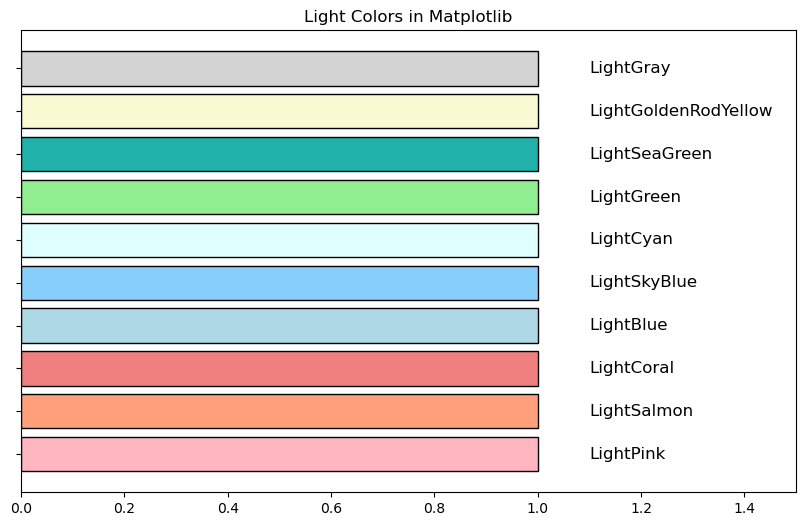

In [34]:
import matplotlib.pyplot as plt

# List of light colors
light_colors = [
    'LightPink', 'LightSalmon', 'LightCoral', 'LightBlue', 'LightSkyBlue', 
    'LightCyan', 'LightGreen', 'LightSeaGreen', 'LightGoldenRodYellow', 'LightGray'
]

# Plotting the colors
fig, ax = plt.subplots(figsize=(10, 6))

for idx, color in enumerate(light_colors):
    ax.barh(idx, 1, color=color, edgecolor='black')
    ax.text(1.1, idx, color, va='center', fontsize=12)

ax.set_xlim(0, 1.5)
ax.set_yticks(range(len(light_colors)))
ax.set_yticklabels([])

plt.title("Light Colors in Matplotlib")
plt.show()
